<a href="https://colab.research.google.com/github/chrislyx/meeting_schedule_optimizer_GA/blob/development/GA_Schedule_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime, time, timedelta, date
from collections.abc import Mapping
import csv
import pandas as pd

In [2]:
'''
Read input csv files exported from Microsoft Outlook.
'''
data = pd.read_csv("wenchang_aug.csv", sep = ',')
#data = pd.read_csv("rafal.csv", sep = ',')
#data = pd.read_csv("chuanjie.csv", sep = ',')
#data = pd.read_csv("huafeng_aug.csv", sep = ',')
#data = pd.read_csv("chris-szlenk.csv", sep = ',')

'''
how to obtain duration of meeting
'''
data["Duration"] = pd.to_datetime(data["EndTime"]) - pd.to_datetime(data["StartTime"])
date_range = set(pd.to_datetime(data["StartTime"]).dt.date)
date_range = sorted(list(date_range))
durations = list(data["Duration"])

'''
obtain initial fitness score of schedule before optimization
'''
# input = list()
# for index, row in data.iterrows():
#   input.append([row['Summary'], pd.Timestamp(row['StartTime']), pd.Timestamp(row['EndTime'])])
# Fitness(input).scheduleFitness()

'\nobtain initial fitness score of schedule before optimization\n'

In [3]:
def random_dates_generator():
  '''
  Initialize a list of dates between a given range.
  '''
  random_dates = []
  # change start and end dates as necessary
  start_date = date(2021, 8, 1)
  end_date = date(2021, 8, 31)

  delta = timedelta(days=1)
  while start_date <= end_date:
    day_name = start_date.weekday()
    if day_name == 5 or day_name == 6:
      start_date += delta
      continue
    else:
      random_dates.append(start_date)
      start_date += delta
  return random_dates

#date_range = random_dates_generator()

In [4]:
'''
Fitness class to score the different schedules generated.
Implemented based on utility of free time counted in contiguous blocks.
'''
class Fitness:
  def __init__(self, meetingList):
    self.meetings = meetingList
    self.fitness = 0
    self.utility = 0
  
  def utilityTime(self, free_time):
    self.freeblocks = 0
    if free_time <= pd.Timedelta("0 days 00:30:00"): # not enough time to get into any deep work
      self.freeblocks += 0
    elif pd.Timedelta("0 days 00:30:00") < free_time <= pd.Timedelta("0 days 01:00:00"): # minimum period to start to get into deep work zone
      self.freeblocks += 0.25
    elif pd.Timedelta("0 days 01:00:00") < free_time <= pd.Timedelta("0 days 02:00:00"): # gradually getting more productive
      #time_diff = free_time - pd.Timedelta("0 days 01:00:00")
      self.freeblocks += 0.5
      #self.freeblocks += (time_diff.total_seconds() / 60)
    elif pd.Timedelta("0 days 02:00:00") < free_time <= pd.Timedelta("0 days 03:00:00"):
      self.freeblocks += 0.75
    else: # deep work zone plateaus
      self.freeblocks += 1
    return self.freeblocks

  def calculateTime(self):
    self.meetings.sort(key=lambda x:x[1])
    self.numOfConflicts = 0
    # meeting_dates = set(x[1].date() for x in self.meetings)
    # no_meeting_days = len(date_range) - len(meeting_dates)
    # if no_meeting_days > 0:
    #   self.utility += (no_meeting_days*2)
    for i in range(0, len(self.meetings)-1):
      if self.meetings[i][1].date() == self.meetings[i+1][1].date(): # must compare the same date
        free_timediff = pd.to_datetime(self.meetings[i+1][1]) - pd.to_datetime(self.meetings[i][2])
        self.utility += self.utilityTime(free_timediff)
        if self.meetings[i][2] > self.meetings[i+1][1]: # checking for overlap in personal meetings
          self.numOfConflicts += 1
          if self.numOfConflicts > 0:
            self.utility = 0
            return self.utility
      else:
        # account for free time between start and end of working hours
        end_free = pd.to_datetime(str(self.meetings[i][1].date()) + " 21:00:00") - pd.to_datetime(self.meetings[i][2])
        start_free = pd.to_datetime(self.meetings[i+1][1]) - pd.to_datetime(str(self.meetings[i+1][1]) + " 13:00:00")
        self.utility += self.utilityTime(end_free)
        self.utility += self.utilityTime(start_free)
    return self.utility     

  def scheduleFitness(self):
    freetime_utility = self.calculateTime()
    if self.numOfConflicts > 0:
      self.fitness = 0
    else:
      self.fitness = freetime_utility
    return self.fitness

In [5]:
def random_time(start, end):
  """
  This function will return a random datetime between two datetime objects.
  It should be in blocks of 30 minutes.
  """
  delta = datetime.strptime(end, "%Y-%m-%d %H:%M:%S") - datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
  int_delta = (delta.days * 24 * 60 * 60) + delta.total_seconds()
  random_second = random.randrange(0, int_delta, 30 * 60)
  return pd.to_datetime(start) + timedelta(seconds=random_second)

def random_date(date):
  '''
  This function returns a random datetime within a given week.
  '''
  week1 = pd.date_range(start='2021-08-02', end='2021-08-06')
  week2 = pd.date_range(start='2021-08-09', end='2021-08-13')
  week3 = pd.date_range(start='2021-08-16', end='2021-08-20')
  week4 = pd.date_range(start='2021-08-23', end='2021-08-27')
  week5 = pd.date_range(start='2021-08-30', end='2021-08-31')
  if date in week1:
    final_date = random.choice(week1)
  elif date in week2:
    final_date = random.choice(week2)
  elif date in week3:
    final_date = random.choice(week3)
  elif date in week4:
    final_date = random.choice(week4)
  elif date in week5:
    final_date = random.choice(week5)   
  return str(final_date)[:10]

def time_overlap(a_start, a_end, meetings):
  '''
  This function checks for overlap in meeting timings.
  '''
  for m in meetings:
    overlap = (a_start < m[2] and m[1] < a_end)
    if overlap == True:
      return overlap
  return overlap

def createSchedule(data):
  '''
  This function creates random invidual of schedules by randomzing and assigning new time slots to meetings.
  '''
  newSchedule = list()
  # randomize the date and time slot of the meeting
  for i in range(0, len(data.index)):
    date = random_date(data.loc[i,"StartTime"][:10])
    start_time = random_time(str(date) + " 13:00:00", str(date) + " 21:00:00")
    # start_time = random_time(data.loc[i,"StartTime"][:10] + " 13:00:00", data.loc[i,"StartTime"][:10] + " 21:00:00")
    duration = pd.to_datetime(data.loc[i,"EndTime"]) - pd.to_datetime(data.loc[i,"StartTime"])
    end_time = start_time + duration
    meetingName = data.loc[i,"Summary"]
    # 'if' condition to enforce no conflict generation of schedules for initial population
    if i > 0:
      for meeting in newSchedule:
          while time_overlap(start_time, end_time, newSchedule[:]) == True:
            date = random_date(data.loc[i,"StartTime"][:10])
            start_time = random_time(str(date) + " 13:00:00", str(date) + " 21:00:00")
            # start_time = random_time(data.loc[i,"StartTime"][:10] + " 13:00:00", data.loc[i,"StartTime"][:10] + " 21:00:00")
            duration = pd.to_datetime(data.loc[i,"EndTime"]) - pd.to_datetime(data.loc[i,"StartTime"])
            end_time = start_time + duration
    newSchedule.append([meetingName, start_time, end_time])
  return newSchedule

def initialPopulation(popSize, data):
  '''
  This function creates our first generation based on the population size we define.
  '''
  population = []
  for i in range(0, popSize):
    population.append(createSchedule(data))
  return population

In [6]:
def rankRoutes(population):
  '''
  This function ranks each individual in the population.
  Our output will be an ordered list with the schedule IDs and each associated fitness score.
  '''
  fitnessResults = {}
  for i in range(0, len(population)):
    fitnessResults[i] = Fitness(population[i]).scheduleFitness()
  return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
def selection(popRanked, eliteSize):
    '''
    This function is implemented as fitness proportional selection.
    Essentially fitness-weighted probability of being selected.
    Elitism included to retain best performing individuals automatically.
    '''
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [8]:
def tournament_selection(popRanked, eliteSize, tourneySize):
  '''
  Alternate implementation of tournament selection.
  A set number of individuals are randomly selected from the population.
  Highest fitness in the group is chosen as the first parent, repeat to choose second parent.
  '''
  selectionResults = []
  tournamentPop = []
  for i in range(0, eliteSize):
      selectionResults.append(popRanked[i][0])
  for i in range(0, len(popRanked) - eliteSize):
    j = 0
    while j < tourneySize:
      tournamentPop.append(popRanked[random.randrange(0, len(popRanked))])
      j += 1
    selectionResults.append(sorted(tournamentPop, key = lambda x: x[1], reverse = True)[0][0])
    tournamentPop = []
  return selectionResults

In [9]:
def matingPool(population, selectionResults):
    '''
    This function extracts the selected individuals into the mating pool for crossover.
    '''
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [10]:
def uniform_breed(p1, p2):
    '''
    This function implements uniform crossover of two parent schedules.
    Probability of selection can be modified for parent with better fitness score.
    '''
    parent1 = sorted(p1, key = lambda x:x[0])
    parent2 = sorted(p2, key = lambda x:x[0])
    if Fitness(parent1).scheduleFitness() > Fitness(parent2).scheduleFitness():
      fitter = parent1
      less_fit = parent2
    else:
      fitter = parent2
      less_fit = parent1
    child = [] 
    for i in range(len(parent1)):
      prob = random.random()
      if prob < 0.75:
        child.append(fitter[i])
      else:
        child.append(less_fit[i])
    return child

In [11]:
def breed(p1, p2):
    '''
    This function implements an ordered two-point crossover of two parent schedules.
    '''
    child = []
    childP1 = []
    childP2 = []
    parent1 = sorted(p1, key = lambda x:x[0])
    parent2 = sorted(p2, key = lambda x:x[0])
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
      childP1.append(parent1[i])

    for i in range(startGene):
      childP2.append(parent2[i])
    
    for i in range(endGene, len(parent2)):
      childP2.append(parent2[i])

    child = childP2[:startGene] + childP1 + childP2[startGene:]
    return child

In [12]:
def breedPopulation(matingpool, eliteSize):
    '''
    This function generalizes the breed function chosen to create our offspring population.
    '''
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [13]:
def mutate(individual, mutationRate):
    '''
    This function implements bit-wise mutation for all meetings in an individual schedule.
    Randomizes a new time slot for individual meetings.
    '''
    for i in range(len(individual)):
      if (random.random() < mutationRate):
        duration = pd.to_datetime(individual[i][2]) - pd.to_datetime(individual[i][1])
        rand_date = random_date(individual[i][1].strftime('%Y-%m-%d'))
        newStart = random_time(str(rand_date) + " 13:00:00", str(rand_date) +" 21:00:00")
        # newStart = random_time(individual[i][1].strftime('%Y-%m-%d') + " 13:00:00", individual[i][2].strftime('%Y-%m-%d') + " 21:00:00")
        individual[i][1] = newStart
        individual[i][2] = newStart + duration
    return individual

In [14]:
def mutatePopulation(population, mutationRate):
    '''
    This function extends the mutate function to run through the new population.
    '''
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [15]:
def nextGeneration(currentGen, eliteSize, tourneySize, mutationRate):
    '''
    This function applies all the necessary procedures of GA to obtain the next generation.
    '''
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [16]:
def geneticAlgorithm(population, popSize, eliteSize, tourneySize, mutationRate, generations):
    '''
    This function creates the initial population of schedules and loops through as many generations as we desire.
    It also returns a plot of the fitness function improvement against the number of generations.
    '''
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, tourneySize, mutationRate)
        progress.append(rankRoutes(pop)[0][1])
        print(rankRoutes(pop)[0])
    
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    plt.plot(progress)
    plt.ylabel('Utility of free time in blocks')
    plt.xlabel('Generation')
    plt.show()
    return bestRoute

(1, 25.75)
(130, 19.5)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(4, 23.0)
(0, 23.75)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(16, 20.5)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


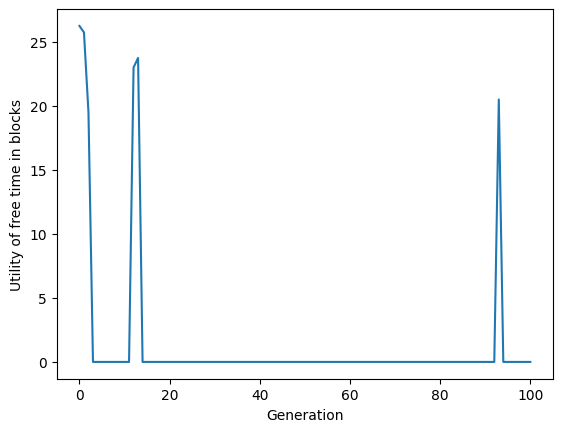

[['chat with Wenchang',
  Timestamp('2021-08-02 13:00:00'),
  Timestamp('2021-08-02 13:30:00')],
 ['Dynamite priorities ',
  Timestamp('2021-08-02 18:00:00'),
  Timestamp('2021-08-02 18:30:00')],
 ['HPC Orientation',
  Timestamp('2021-08-02 19:30:00'),
  Timestamp('2021-08-02 20:15:00')],
 ['1 on 1 with Wenchang Zhou',
  Timestamp('2021-08-03 14:00:00'),
  Timestamp('2021-08-03 14:30:00')],
 ['Membrane permeability meeting/potential collaboration',
  Timestamp('2021-08-03 14:30:00'),
  Timestamp('2021-08-03 15:30:00')],
 ['Final Intern Presentation - Tom Dixon',
  Timestamp('2021-08-03 20:00:00'),
  Timestamp('2021-08-03 21:00:00')],
 ['chat with Sam',
  Timestamp('2021-08-04 15:00:00'),
  Timestamp('2021-08-04 15:30:00')],
 ['Jason Imbriglio <> Wenchang Zhou 1:1',
  Timestamp('2021-08-04 20:00:00'),
  Timestamp('2021-08-04 20:30:00')],
 ['Weekly Platform Meeting',
  Timestamp('2021-08-05 13:30:00'),
  Timestamp('2021-08-05 15:00:00')],
 ['Advanced simulations biweekly',
  Timestamp('2

In [17]:
geneticAlgorithm(population=data, popSize=250, eliteSize=50, tourneySize = 50, mutationRate=0.05, generations=100)